# Task 3
> Using the models.ldamodel module from the gensim library, run topic modeling over the corpus. Explore different numbers of topics (varying from 5 to 50), and settle for the parameter which returns topics that you consider to be meaningful at first sight.

In [1]:
import pandas as pd
import nltk
import pickle
from gensim.models.ldamodel import LdaModel
from gensim import corpora

%matplotlib inline
import matplotlib.pyplot as plt

/home/weizhang/.local/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


# Text pre-processing

### Preprocess data

We start by loading the dataset and preprocessing its text field. We notice that in addition to ExtractedBodyText field, MetadataSubject field also contains much important information. So we decide to build our topic model on a combination of these two fields. We merge the ExtractBodyText column and MetadataSubject column into a new column named MergedText.

In [2]:
emails = pd.read_csv('hillary-clinton-emails/Emails.csv')

In [3]:
# return the concatenation of ExtractedBodyText and MetadataSubject fields
def concat_text(x):
    return str(x.ExtractedBodyText) + ' ' + str(x.MetadataSubject)

emails['MergedText'] = emails.apply(concat_text, axis=1)

In [4]:
emails['MetadataSubject'][1]

'H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MORE... SID'

In [5]:
emails['MergedText'][1]

'B6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\nMarch 3, 2011\nFor: Hillary H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MORE... SID'

### Text-preprocessing pipeline

We then perform a standard text pre-processing pipeline (e.g., tokenization, stopword removal, stemming, etc.) as in task 1. 

1. <b>tokenlization</b>: we use <em>word_tokenize</em> method of nltk
2. <b>lowercase tokens</b>: we lowercase all tokens to merge the same words
3. <b>remove tokens without leading letters</b>: We remove tokens not started with a letter, to exclude punctuations and some meaningless tokens. Otherwise, topics generated are likely to have meaningless tokens. We only require the leading character of tokens to be alphabetic letters, instead of all characters to be alphabetic letters, because words like 'u.s.' do have non-alphabetic character '.' inside the word.
2. <b>stopword removel</b>: we define our stop words by standard stop words and specific words common in emails.
3. <b>stemming</b>: We use PorterStemmer for stemming.

We define our stop words by standard stop words and specific words common in emails.

In [6]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
local_stop = {"Re", "RE", "Fw", "FW", "Cc", "also", "PM", "AM", "pm", "am", "btw", "fyi", "FYI", "to", "from", "To", "From"}
stop_words = stop_words | local_stop

We use PorterStemmer for stemming.

In [7]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [8]:
# preprocess a MergedText field
def preprocess(text):
    # 1. tokenlization
    tokens = nltk.word_tokenize(text)

    # 2. lowercase tokens
    tokens_lowercased = [t.lower() for t in tokens]
    
    # 3. remove tokens without a leading letter
    tokens_started_with_letter = [t for t in tokens_lowercased if t[0].isalpha()] 

    # 4. remove stop words 
    tokens_without_stop_words = [t for t in tokens_started_with_letter if t not in stop_words]
    
    # 5. stemming
    stemmed_tokens = [ps.stem(t) for t in tokens_without_stop_words]
    
    return stemmed_tokens

In [9]:
texts = [ preprocess(text) for text in emails.MergedText]

# Topic modeling

We construct a dictionary which map every token to a unique ID.

In [10]:
dictionary = corpora.Dictionary(texts)

We build corpus according to the directionay.

In [11]:
corpus = [dictionary.doc2bow(text) for text in texts]

Then, let's train the LDA model with different number of topics.  

TODO: try different number of topics, number of words, number of passes and find a good fit.

In [13]:
N_TOPICS = 20
N_PASSES = 20 # number of iterations
model = LdaModel(corpus, num_topics=N_TOPICS, id2word=dictionary, passes=N_PASSES)

In [14]:
model.print_topics()

[(0,
  '0.286*"nan" + 0.041*"ap" + 0.035*"reuter" + 0.024*"updat" + 0.010*"pakistan" + 0.008*"report" + 0.007*"bob" + 0.007*"hama" + 0.006*"telephon" + 0.006*"glenn"'),
 (1,
  '0.032*"pl" + 0.028*"print" + 0.023*"richard" + 0.012*"lieberman" + 0.012*"sent" + 0.010*"dr." + 0.009*"stori" + 0.009*"amcit" + 0.008*"wireless" + 0.007*"roger"'),
 (2,
  '0.079*"sid" + 0.047*"h" + 0.036*"memo" + 0.028*"hillari" + 0.025*"clinton" + 0.014*"hrc" + 0.013*"per" + 0.012*"may" + 0.012*"import" + 0.011*"urgent"'),
 (3,
  '0.026*"afghan" + 0.025*"mr" + 0.018*"tea" + 0.017*"afghanistan" + 0.015*"taliban" + 0.015*"tori" + 0.013*"ireland" + 0.012*"cameron" + 0.012*"northern" + 0.012*"us"'),
 (4,
  '0.056*"h" + 0.045*"state.gov" + 0.029*"fw" + 0.027*"huma" + 0.026*"cheryl" + 0.022*"mill" + 0.019*"clintonemail.com" + 0.018*"abedin" + 0.017*"hrod17" + 0.016*"sullivan"'),
 (5,
  '0.069*"secretari" + 0.061*"offic" + 0.043*"depart" + 0.035*"meet" + 0.030*"state" + 0.027*"room" + 0.021*"arriv" + 0.019*"rout" + 0.

# Topic visualisation

We build a WordCloud of every topic to show it more clearly, since the frequency of words is not intuitive to see.

In [29]:
from wordcloud import WordCloud

In [30]:
def plot_wordcloud(word_freq_tuples):
    plt.figure()
    plt.imshow(WordCloud(max_font_size=40).fit_words(word_freq_tuples))
    plt.axis("off")
    plt.show()

In [31]:
def visualise_topics(topics):
    for topic in topics:
        word_freq_tuples = topic[1]
        plot_wordcloud(word_freq_tuples)#word_freq_tuples)

In [32]:
topics = model.show_topics(num_topics=10, formatted=False)

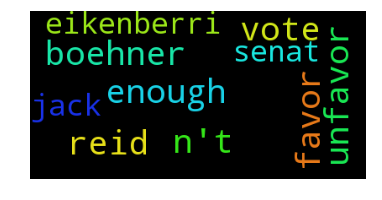

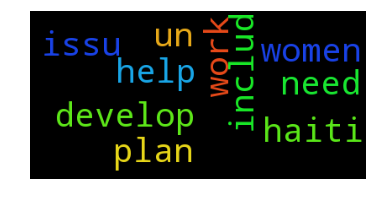

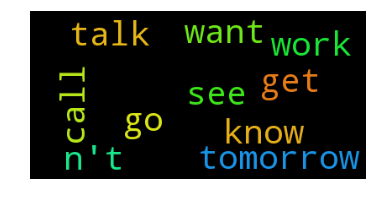

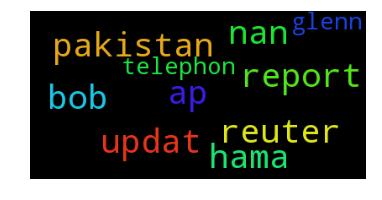

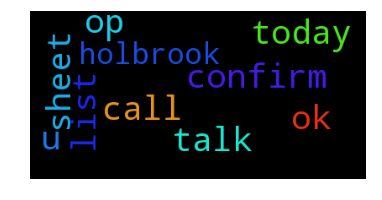

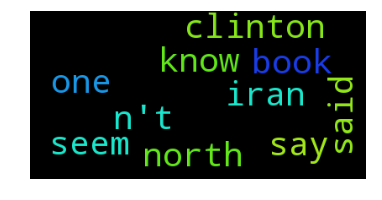

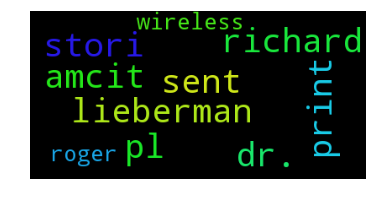

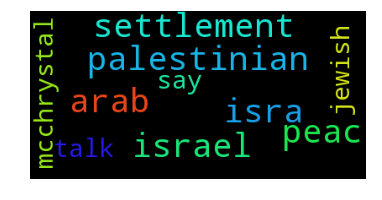

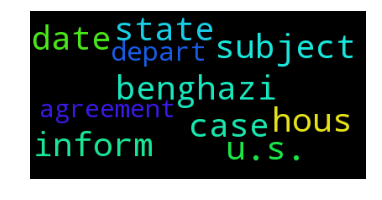

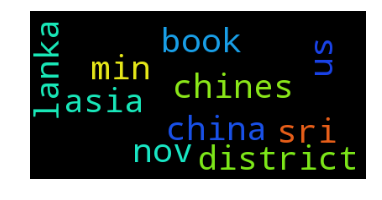

In [33]:
visualise_topics(topics)

# Result Interpretation and Conclusion

### TODO
